In [ ]:
# pip install openslide-python
# pip install openslide-bin

In [7]:
import os
from openslide import open_slide
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from openslide.deepzoom import DeepZoomGenerator
from skimage.filters import threshold_otsu
import math
import zipfile

import cv2
import skimage.filters
from skimage import color, measure
from skimage.feature import canny
from scipy.stats import entropy


from PIL import Image

In [30]:
# variables

# Define directory for saving tiles
TRAIN_DATASET_DIR = "train_dataset"

    
raw_train_images_path = "raw_train"
inp_size=224
overlap_pixels = 70

trained_model_path  = 'MODELS/new_final_effB0_res152_vgg19_stacked.h5_trained.keras'

In [4]:
def unzip_all_files(directory):
    # Iterate through all files in the directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.zip'):
                file_path = os.path.join(root, file)
                # Create a ZipFile object
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    # Extract all the contents into the same directory
                    zip_ref.extractall(root)
                print(f"Unzipped: {file_path}")

unzip_all_files(raw_train_images_path)

In [5]:
raw_train_df = pd.read_csv('train.csv')
raw_train_df.head()

image_id  center_id patient_id  image_num label
0  006388_0         11     006388          0    CE
1  008e5c_0         11     008e5c          0    CE
2  00c058_0         11     00c058          0   LAA
3  01adc5_0         11     01adc5          0   LAA
4  026c97_0          4     026c97          0    CE

In [6]:
temp = raw_train_df[raw_train_df['image_id'].isin(['f9fc6b_1'])]
temp

image_id  center_id patient_id  image_num label
726  f9fc6b_1         11     f9fc6b          1   LAA

In [7]:
def get_all_files(directory):
    file_list = []
    
    # Walk through the directory recursively
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Append the file name to the list
            if file.endswith(".tif"):
                file_list.append(file.split(".")[0])
    
    return file_list

# Example usage
list_of_available_images = get_all_files(raw_train_images_path)

In [8]:
train_df = raw_train_df[raw_train_df['image_id'].isin(list_of_available_images)]

In [9]:
train_df.label.value_counts()

label
CE     22
LAA    21
Name: count, dtype: int64

In [10]:
def form_train_images_paths(x):
    current_file_path = os.path.join(raw_train_images_path, x+'.tif')
    if os.path.isfile(current_file_path):
        return current_file_path
    elif os.path.isdir(current_file_path):
         return os.path.join(current_file_path , x+'.tif')
        
train_df.image_id = train_df.image_id.apply(form_train_images_paths)

C:\Users\Raghava\AppData\Local\Temp\ipykernel_15376\3057052148.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.image_id = train_df.image_id.apply(form_train_images_paths)


In [11]:
train_df.drop(columns=["center_id", "patient_id", "image_num"], inplace=True)

C:\Users\Raghava\AppData\Local\Temp\ipykernel_15376\4186856123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=["center_id", "patient_id", "image_num"], inplace=True)


In [12]:
# train_df.head()
train_df.reset_index(inplace = True, drop = True)

In [13]:
train_df.head(40)

image_id label
0   raw_train\008e5c_0.tif\008e5c_0.tif    CE
1                raw_train\00c058_0.tif   LAA
2                raw_train\01adc5_0.tif   LAA
3   raw_train\026c97_0.tif\026c97_0.tif    CE
4   raw_train\032f10_0.tif\032f10_0.tif    CE
5   raw_train\0372b0_0.tif\0372b0_0.tif    CE
6                raw_train\055f6a_0.tif   LAA
7   raw_train\0aaeb3_0.tif\0aaeb3_0.tif    CE
8   raw_train\0aff58_0.tif\0aff58_0.tif    CE
9   raw_train\0cc0bc_0.tif\0cc0bc_0.tif    CE
10  raw_train\0e696a_1.tif\0e696a_1.tif    CE
11  raw_train\0ed87f_0.tif\0ed87f_0.tif    CE
12  raw_train\0ed87f_1.tif\0ed87f_1.tif    CE
13  raw_train\0ff890_0.tif\0ff890_0.tif    CE
14  raw_train\15aab4_0.tif\15aab4_0.tif    CE
15  raw_train\20d5cf_0.tif\20d5cf_0.tif    CE
16  raw_train\2a25b9_0.tif\2a25b9_0.tif   LAA
17  raw_train\369366_0.tif\369366_0.tif    CE
18  raw_train\4f6fb1_1.tif\4f6fb1_1.tif    CE
19  raw_train\4f9ac6_0.tif\4f9ac6_0.tif    CE
20               raw_train\c61b26_0.tif    CE
21               raw_train\c78d6b_0.tif    CE
22               raw_train\c92b51_0.tif    CE
23               raw_train\ca2f66_0.tif    CE
24               raw_train\ca7b57_0.tif   LAA
25               raw_train\caf901_0.tif    CE
26               raw_train\d862da_0.tif   LAA
27               raw_train\d8db68_0.tif   LAA
28               raw_train\dae554_0.tif   LAA
29               raw_train\dba56f_0.tif   LAA
30               raw_train\de9e4c_0.tif   LAA
31               raw_train\e251ff_0.tif    CE
32               raw_train\e26a04_0.tif   LAA
33               raw_train\e26a04_1.tif   LAA
34               raw_train\ed5006_0.tif   LAA
35               raw_train\f3e9f6_0.tif   LAA
36               raw_train\f3e9f6_1.tif   LAA
37               raw_train\f40c69_0.tif   LAA
38               raw_train\f40c69_1.tif   LAA
39               raw_train\f7fb11_0.tif   LAA

Filepath: raw_train\008e5c_0.tif\008e5c_0.tif, Label: CE
<_PropertyMap {'openslide.level-count': '1', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '29694', 'openslide.level[0].tile-height': '128', 'openslide.level[0].tile-width': '128', 'openslide.level[0].width': '5946', 'openslide.mpp-x': '1000', 'openslide.mpp-y': '1000', 'openslide.vendor': 'generic-tiff', 'tiff.ResolutionUnit': 'centimeter', 'tiff.XResolution': '10', 'tiff.YResolution': '10'}>
Slide Dimensions: (5946, 29694)
Slide Level Dimensions: ((5946, 29694),)


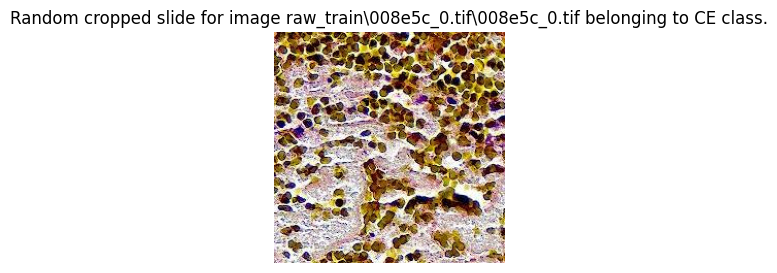

Total levels: 16
Dimensions per level: ((1, 1), (1, 2), (1, 4), (2, 8), (3, 15), (6, 29), (12, 58), (24, 116), (47, 232), (93, 464), (186, 928), (372, 1856), (744, 3712), (1487, 7424), (2973, 14847), (5946, 29694))
Total tiles: 4871
Printing information for level 1 from last:
Tile grid size at this level: (27, 133)
Each tile's dimension: (224, 224)


In [14]:
def understand_single_WSI(id,show_gridded_tiles=False):
    file_path = train_df.loc[id, "image_id"]
    label = train_df.loc[id, "label"]
    print(f"Filepath: {file_path}, Label: {label}")

    slide = open_slide(file_path)
    print(slide.properties)
    print(f"Slide Dimensions: {slide.dimensions}")
    print(f"Slide Level Dimensions: {slide.level_dimensions}")
    
    #in the slide object, we have only 1 level bcoz it is the way it was stored originally
    #so that is why we can only view images of original resolution

    # Read a small cropped region for visualization
    small_region = slide.read_region((1600, 28800), 0, (inp_size, inp_size)).convert("RGB")    # (x,y) from top-left, level, (width,height)
    small_region = np.array(small_region)

    plt.figure(figsize=(3, 3))
    plt.title(f"Random cropped slide for image {file_path} belonging to {label} class.")
    plt.imshow(small_region)
    plt.axis("off")  # Hide axes
    plt.show()

    # DeepZoomGenerator for tiling
    tiles = DeepZoomGenerator(slide, tile_size=inp_size, overlap=0, limit_bounds=False)
    
    level_from_last_to_focus = 1
    focus_level = tiles.level_count - level_from_last_to_focus
    
    print(f"Total levels: {tiles.level_count}")
    print(f"Dimensions per level: {tiles.level_dimensions}")
    print(f"Total tiles: {tiles.tile_count}")
    print(f"Printing information for level {level_from_last_to_focus} from last:")
    print(f"Tile grid size at this level: {tiles.level_tiles[focus_level]}")
    print(f"Each tile's dimension: {tiles.get_tile_dimensions(focus_level, (0, 0))}")

    if show_gridded_tiles:
        cols, rows = tiles.level_tiles[focus_level]
    
        # Set up grid for visualizationshow_gridded_tiles
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        
        if rows == 1 and cols == 1:
            axes = np.array([[axes]])  # Ensure 2D array for single tile
        elif rows == 1 or cols == 1:
            axes = np.expand_dims(axes, axis=0 if rows == 1 else 1)  # Expand to 2D
        
        for row in range(rows):
            for col in range(cols):
                file_name = f"{file_path}_{col}_{row}_{label}.png"
                tile = tiles.get_tile(focus_level, (col, row)).convert("RGB")
                tile = np.array(tile)
    
                ax = axes[row, col]
                ax.set_title(file_name, fontsize=6)
                ax.imshow(tile)
                ax.axis("off")  # Hide axes for clean visualization
    
        plt.tight_layout()
        plt.show()

understand_single_WSI(0)

Filepath: raw_train\00c058_0.tif, Label: LAA
<_PropertyMap {'openslide.level-count': '1', 'openslide.level[0].downsample': '1', 'openslide.level[0].height': '61801', 'openslide.level[0].tile-height': '128', 'openslide.level[0].tile-width': '128', 'openslide.level[0].width': '15255', 'openslide.mpp-x': '1000', 'openslide.mpp-y': '1000', 'openslide.vendor': 'generic-tiff', 'tiff.ResolutionUnit': 'centimeter', 'tiff.XResolution': '10', 'tiff.YResolution': '10'}>
Slide Dimensions: (15255, 61801)
Slide Level Dimensions: ((15255, 61801),)


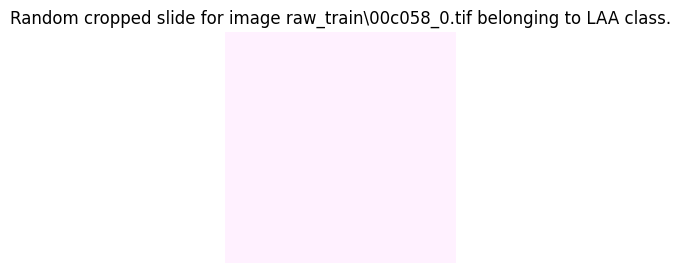

Total levels: 17
Dimensions per level: ((1, 1), (1, 2), (1, 4), (2, 8), (4, 16), (8, 31), (15, 61), (30, 121), (60, 242), (120, 483), (239, 966), (477, 1932), (954, 3863), (1907, 7726), (3814, 15451), (7628, 30901), (15255, 61801))
Total tiles: 25571
Printing information for level 1 from last:
Tile grid size at this level: (69, 276)
Each tile's dimension: (224, 224)


In [15]:
understand_single_WSI(1)

In [19]:
def create_dirs(label):
    """Creates directory structure for saving tiles."""
    label_dir = os.path.join(TRAIN_DATASET_DIR, str(label))
    os.makedirs(label_dir, exist_ok=True)
    return label_dir

def contains_dark_patches(tile, dark_threshold=50, dark_ratio=0.05):
    """
    Checks if a tile contains any dark patches beyond a certain threshold.
    """
    gray_tile = np.mean(np.array(tile), axis=-1)
    dark_pixels = np.sum(gray_tile < dark_threshold)
    total_pixels = gray_tile.size
    return (dark_pixels / total_pixels) > dark_ratio

def is_blurry(tile, laplacian_threshold=200):
    """
    Checks if a tile is blurry using the variance of the Laplacian method.
    """
    gray_tile = cv2.cvtColor(np.array(tile), cv2.COLOR_RGB2GRAY)
    laplacian_var = cv2.Laplacian(gray_tile, cv2.CV_64F).var()
    return laplacian_var < laplacian_threshold

def is_useful_tile(tile, intensity_threshold=150, variance_threshold=500):
    """
    Filters tiles based on:
    - Mean intensity (removes mostly white/empty tiles)
    - Variance threshold (removes low-information tiles)
    - Full coverage of nuclei, plasma, and cytoplasm
    - No dark patches
    - No blurriness
    """
    tile_array = np.array(tile, dtype=np.uint8)
    gray_tile = np.mean(tile_array, axis=-1)
    
    mean_intensity = np.mean(gray_tile)
    variance = np.var(gray_tile)
    
    return (
        mean_intensity < intensity_threshold and mean_intensity > 90 and
        variance > variance_threshold and
        not contains_dark_patches(tile) and
        not is_blurry(tile)
    )



def preprocess_single_WSI(id, plot_all_grided_images=False, save_files=False,preprocess_tiles=True):
    """Extracts, filters, and saves important tiles from a whole-slide image."""
    file_path = train_df.loc[id, "image_id"]
    label = train_df.loc[id, "label"]
    print(f"Processing: {file_path}, Label: {label}")

    base_filename = os.path.basename(file_path).replace("/", "_").replace("\\", "_")
    slide = open_slide(file_path)
    tiles = DeepZoomGenerator(slide, tile_size=inp_size, overlap=overlap_pixels, limit_bounds=False)

    focus_level = tiles.level_count - 1
    cols, rows = tiles.level_tiles[focus_level]
    save_dir = create_dirs(label)

    useful_tiles = []
    useful_tile_count = 0

    for row in range(rows):
        for col in range(cols):
            tile = tiles.get_tile(focus_level, (col, row)).convert("RGB")
            
            if is_useful_tile(tile):
                print("tile found useful")
                if preprocess_tiles : tile = preprocess_tile(tile)
                # if not is_useful_tile(tile):continue
                if save_files:
                    file_name = f"{base_filename}_{col}_{row}.png"
                    save_path = os.path.join(save_dir, file_name)
                    tile.save(save_path)
                useful_tiles.append(np.array(tile))
                useful_tile_count += 1
            if (not save_files) and useful_tile_count >= 20:
                break
        if (not save_files) and useful_tile_count >= 20:
            break

    print(f"Saved {useful_tile_count} useful tiles in '{save_dir}'.")

    if plot_all_grided_images and useful_tiles:
        grid_size = math.ceil(math.sqrt(len(useful_tiles)))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
        
        for i, tile_img in enumerate(useful_tiles):
            axes[i].imshow(tile_img)
            axes[i].axis("off")
        
        for j in range(i + 1, len(axes)):
            axes[j].axis("off")
        
        plt.suptitle(f"Tiled Images for {base_filename} (Label: {label})", fontsize=14)
        plt.show()


In [28]:
def norm_HnE(img, Io=250, alpha=1, beta=0.15):


    ######## Step 1: Convert RGB to OD ###################
    ## reference H&E OD matrix.
    #Can be updated if you know the best values for your image. 
    #Otherwise use the following default values. 
    #Read the above referenced papers on this topic. 
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
    ### reference maximum stain concentrations for H&E
    maxCRef = np.array([1.9705, 1.0308])
    
    
    # extract the height, width and num of channels of image
    h, w, c = img.shape
    
    # reshape image to multiple rows and 3 columns.
    #Num of rows depends on the image size (wxh)
    img = img.reshape((-1,3))
    
    # calculate optical density
    # OD = −log10(I)  
    #OD = -np.log10(img+0.004)  #Use this when reading images with skimage
    #Adding 0.004 just to avoid log of zero. 
    
    OD = -np.log10((img.astype(float)+1)/Io) #Use this for opencv imread
    #Add 1 in case any pixels in the image have a value of 0 (log 0 is indeterminate)
    
    
    ############ Step 2: Remove data with OD intensity less than β ############
    # remove transparent pixels (clear region with no tissue)
    ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
    #Check by printing ODhat.min()
    
    ############# Step 3: Calculate SVD on the OD tuples ######################
    #Estimate covariance matrix of ODhat (transposed)
    # and then compute eigen values & eigenvectors.
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))
    
    
    ######## Step 4: Create plane from the SVD directions with two largest values ######
    #project on the plane spanned by the eigenvectors corresponding to the two 
    # largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3]) #Dot product
    
    ############### Step 5: Project data onto the plane, and normalize to unit length ###########
    ############## Step 6: Calculate angle of each point wrt the first SVD direction ########
    #find the min and max vectors and project back to OD space
    phi = np.arctan2(That[:,1],That[:,0])
    
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)
    
    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)
    
    
    # a heuristic to make the vector corresponding to hematoxylin first and the 
    # one corresponding to eosin second
    if vMin[0] > vMax[0]:    
        HE = np.array((vMin[:,0], vMax[:,0])).T
        
    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T
    
    
    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T
    
    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]
    
    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])
    
    ###### Step 8: Convert extreme values back to OD space
    # recreate the normalized image using reference mixing matrix 
    
    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  
    
    # Separating H and E components
    
    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)
    
    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)
    
    return (Inorm, H, E)

def preprocess_tile(image):
    """
    Enhanced preprocessing pipeline for WSI tiles:
    1. **H&E Normalization**
    2. **Contrast & Color Normalization**
    3. **Feature Highlighting** (CE: fibrin, LAA: RBC clusters)
    4. **Edge & Structure Sharpening**
    """
    image = np.array(image)
    image,H,E = norm_HnE(image)
    return Image.fromarray(image)
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:, :, 2] = cv2.equalizeHist(hsv[:, :, 2])
    normalized = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    gray = cv2.cvtColor(normalized, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    laplacian = cv2.Laplacian(enhanced, cv2.CV_64F)
    sharpened = cv2.convertScaleAbs(enhanced - 0.5 * laplacian)
    
    blurred = cv2.GaussianBlur(sharpened, (5, 5), 0)
    edges = cv2.Canny(blurred, threshold1=30, threshold2=100)
    enhanced_features = cv2.addWeighted(sharpened, 0.8, edges, 0.2, 0)
    
    kernel = np.ones((3, 3), np.uint8)
    enhanced_fibrin = cv2.morphologyEx(enhanced_features, cv2.MORPH_CLOSE, kernel)
    
    return Image.fromarray(enhanced_fibrin)


Processing: raw_train\0ed87f_1.tif\0ed87f_1.tif, Label: CE
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
Saved 20 useful tiles in 'train_dataset\CE'.


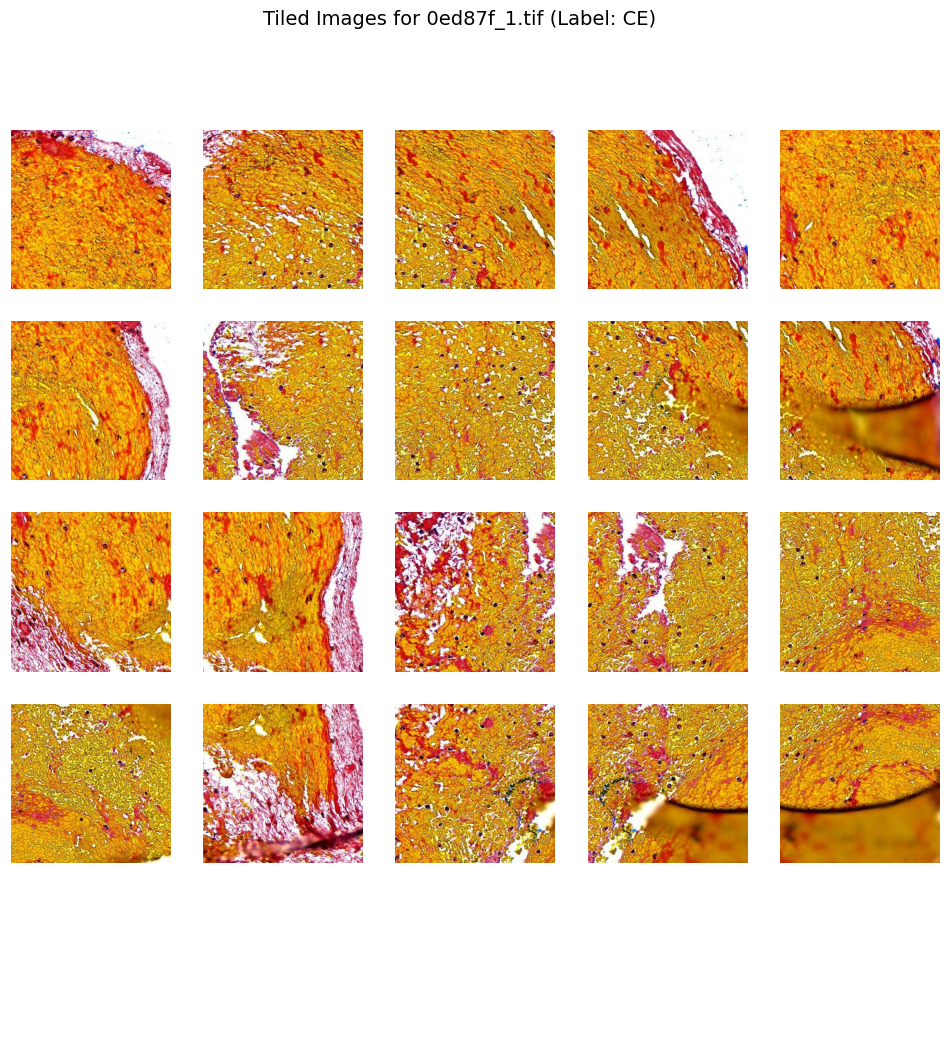

In [20]:
id = 12
preprocess_single_WSI(id=id, plot_all_grided_images=True,preprocess_tiles = False)

Processing: raw_train\f7fb11_0.tif, Label: LAA
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
Saved 20 useful tiles in 'train_dataset\LAA'.


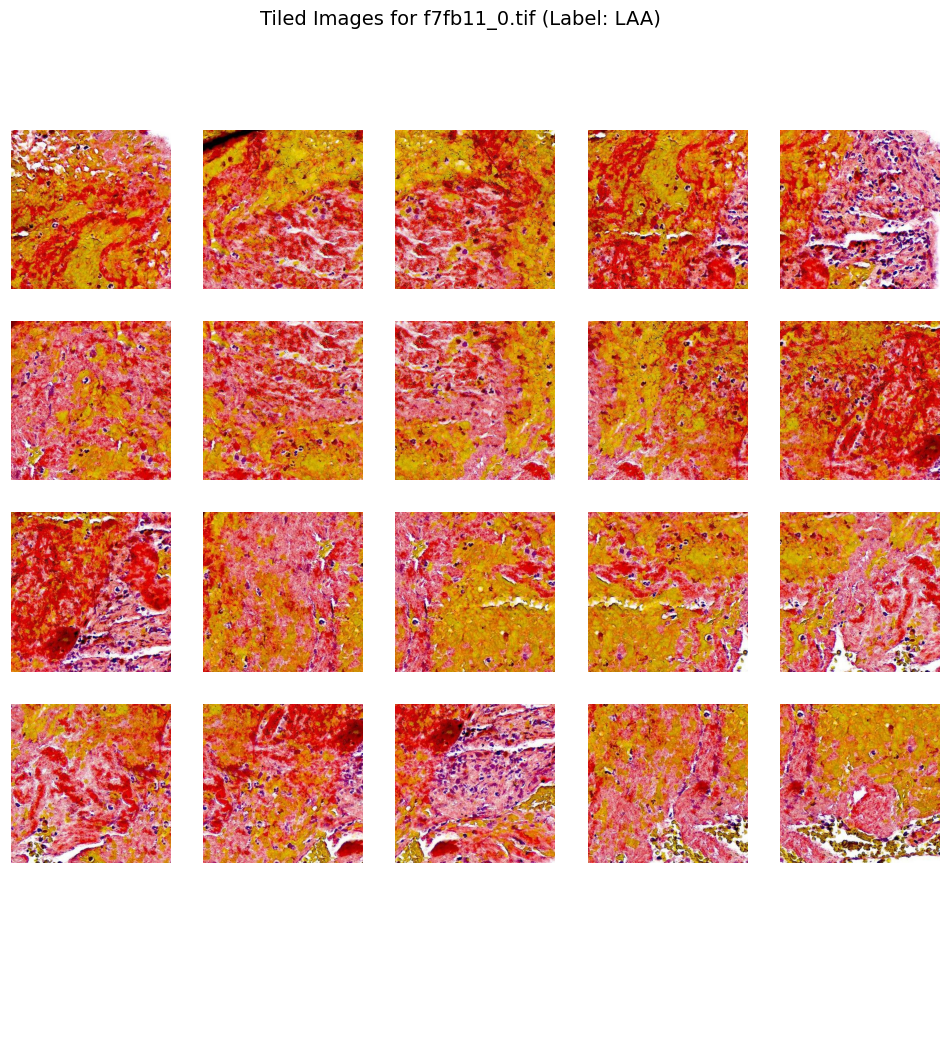

In [21]:
id = 39
preprocess_single_WSI(id=id, plot_all_grided_images=True,preprocess_tiles = False)

Processing: raw_train\0ed87f_1.tif\0ed87f_1.tif, Label: CE
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
Saved 20 useful tiles in 'train_dataset\CE'.


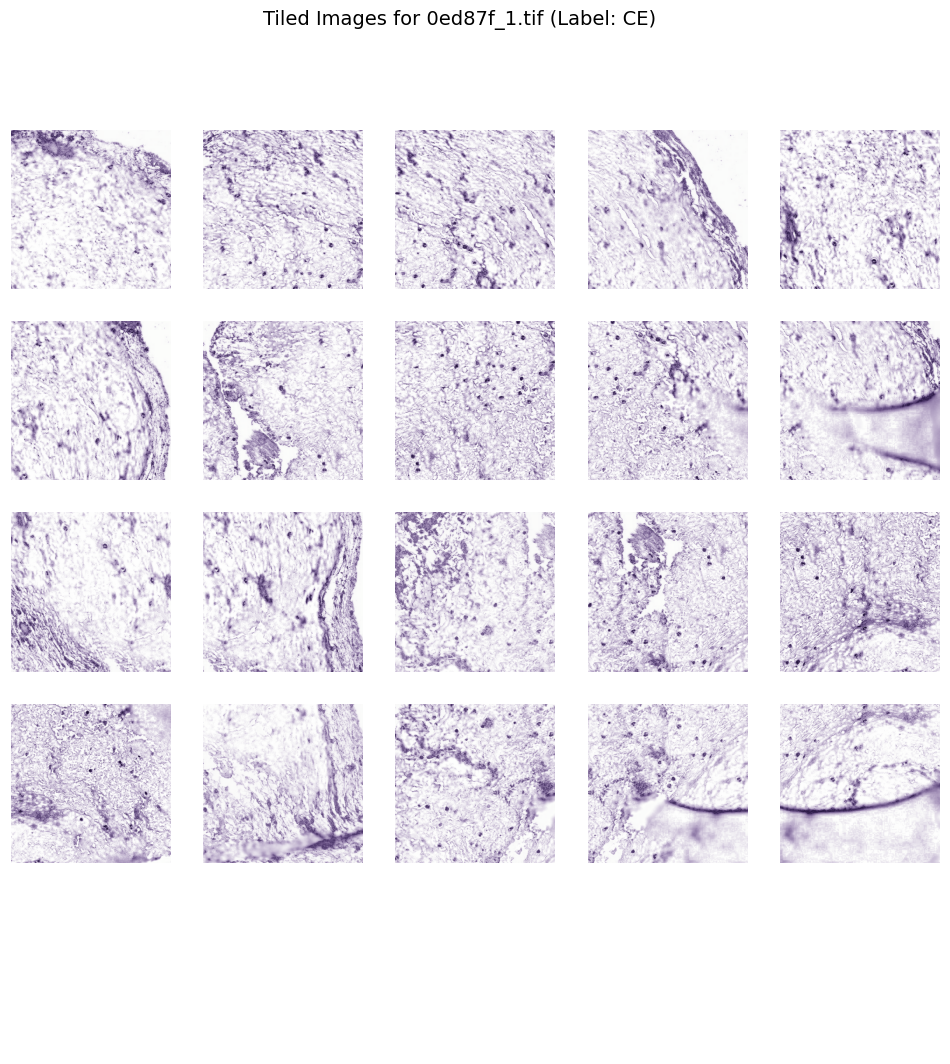

In [23]:
id = 12
preprocess_single_WSI(id=id, plot_all_grided_images=True,preprocess_tiles = True)

Processing: raw_train\f7fb11_0.tif, Label: LAA
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
Saved 20 useful tiles in 'train_dataset\LAA'.


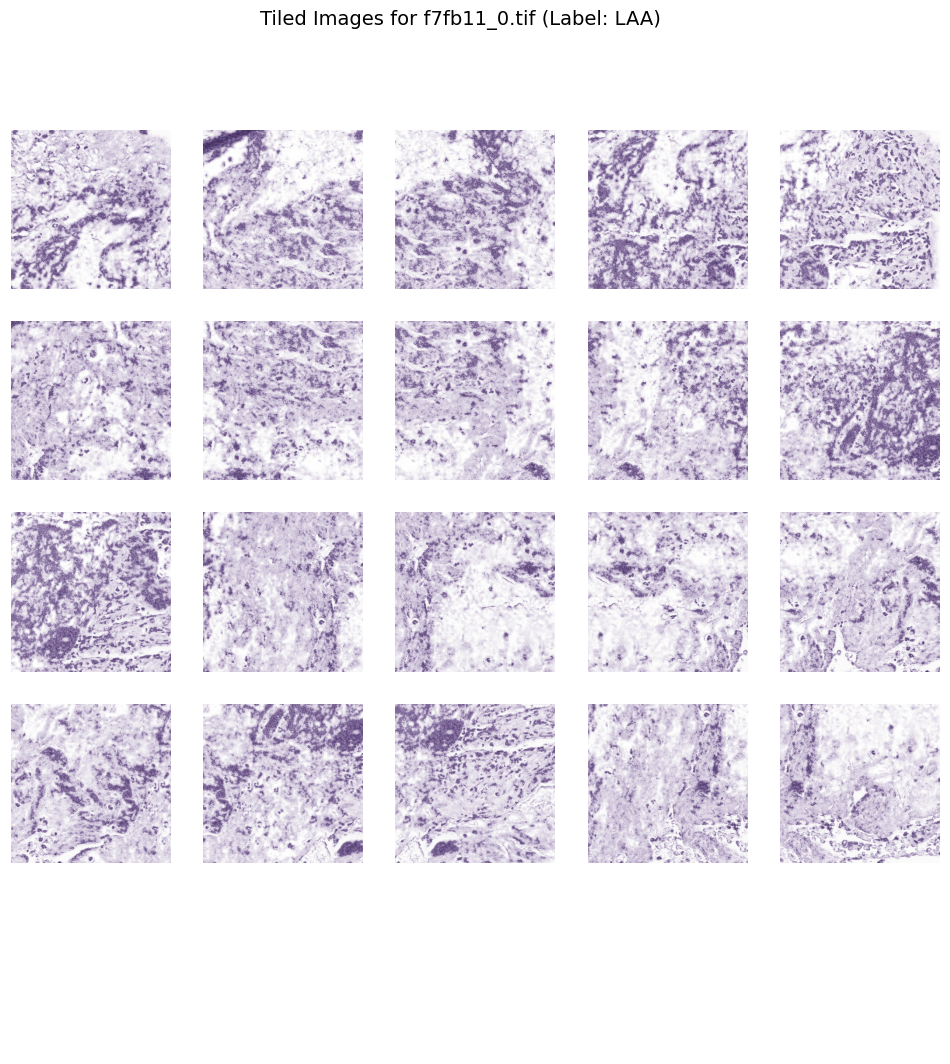

In [24]:
id = 39
preprocess_single_WSI(id=id, plot_all_grided_images=True,preprocess_tiles = True)

Processing: raw_train\0ed87f_1.tif\0ed87f_1.tif, Label: CE
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
Saved 20 useful tiles in 'train_dataset\CE'.


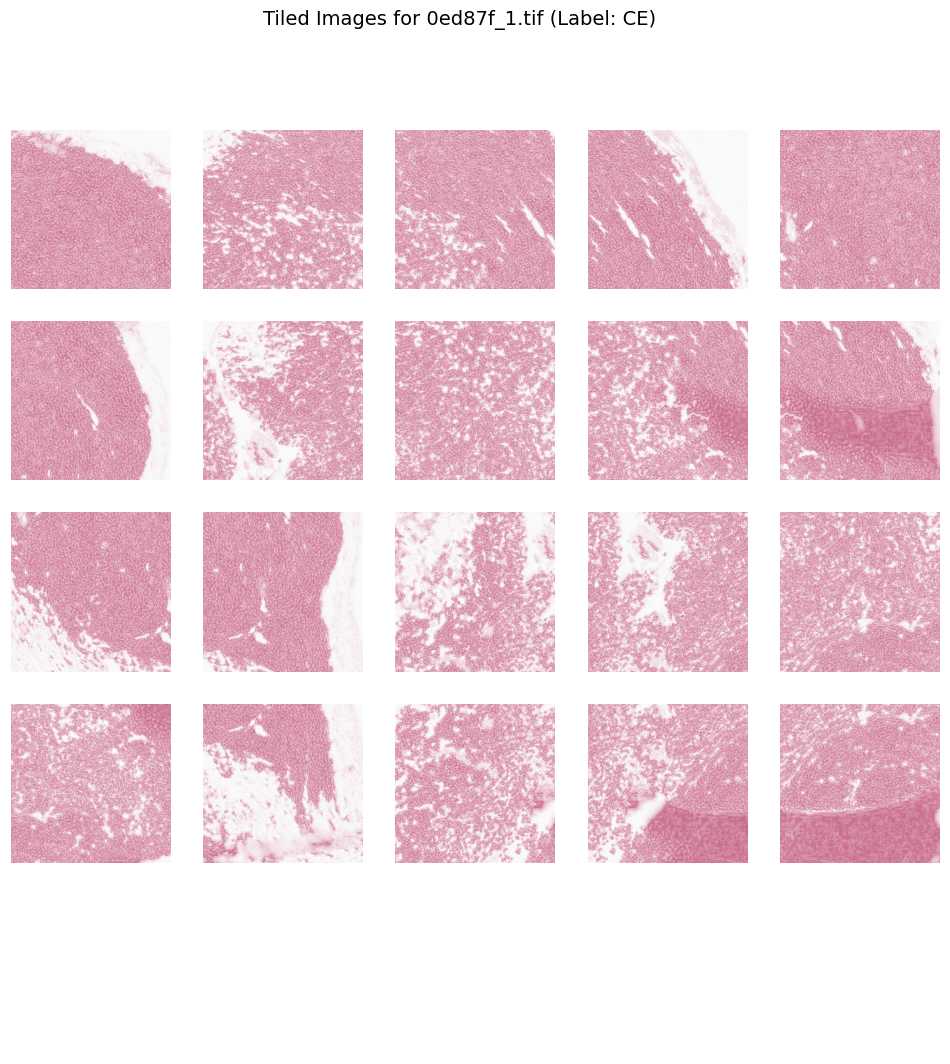

In [26]:
id = 12
preprocess_single_WSI(id=id, plot_all_grided_images=True,preprocess_tiles = True)

Processing: raw_train\f7fb11_0.tif, Label: LAA
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
tile found useful
Saved 20 useful tiles in 'train_dataset\LAA'.


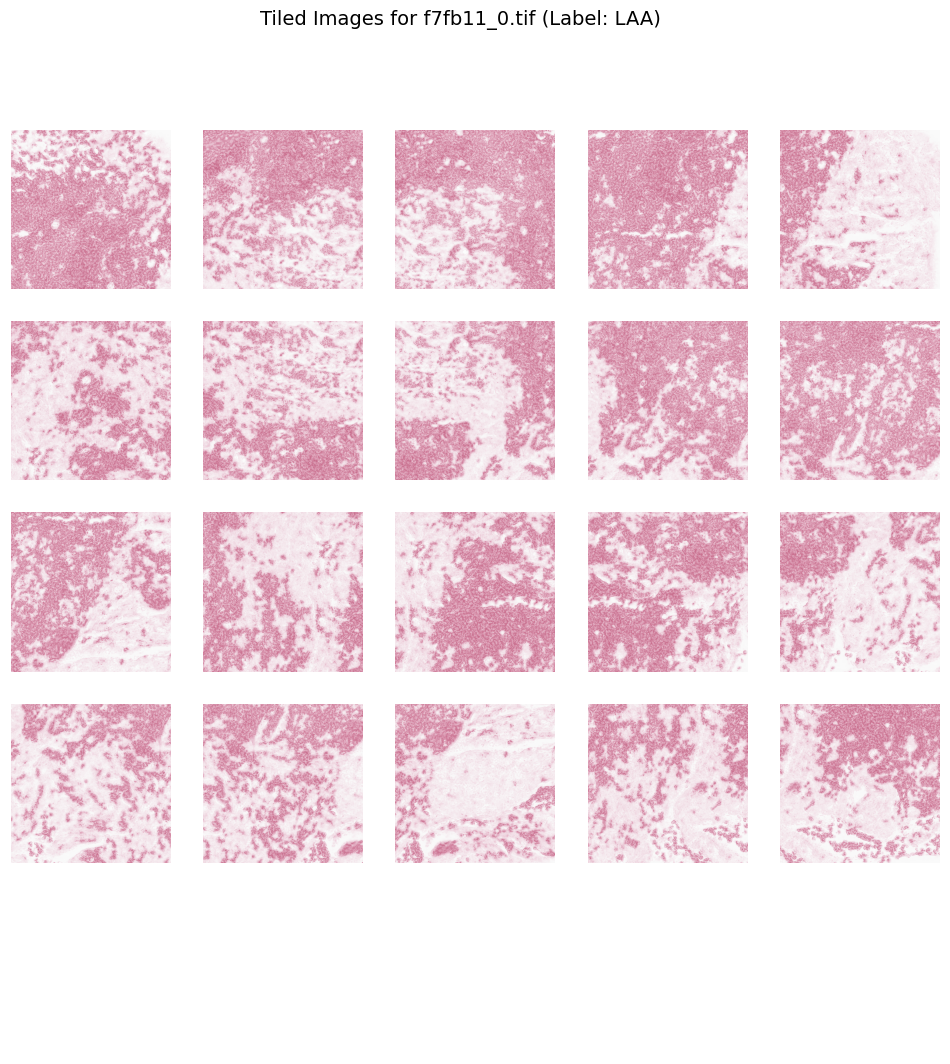

In [27]:
id = 39
preprocess_single_WSI(id=id, plot_all_grided_images=True,preprocess_tiles = True)

In [ ]:
for idx in train_df.index:
    preprocess_single_WSI(idx, plot_all_grided_images=False, save_files=True, preprocess_tiles=True)

### Once the model is trained, come back here to make predictions on test data

In [31]:
import tensorflow as tf

# Load the model
loaded_model = tf.keras.models.load_model(f'{trained_model_path}')

# Check the model summary to confirm it loaded correctly
loaded_model.summary()

C:\Users\Raghava\Documents\PROJECTS\3-Image classification of Blood clot stroke Origin\openslide\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ efficientnetb0 (Functional)   │ (None, 7, 7, 1280)        │       4,049,571 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet152 (Functional)        │ (None, 7, 7, 2048)        │      58,370,944 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg19 (Functional)            │ (None, 7, 7, 512)         │      20,024,384 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_3    │ (None, 1280)              │               0 │ efficientnetb0[0][0]       │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_4    │ (None, 2048)              │               0 │ resnet152[0][0]            │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling2d_5    │ (None, 512)               │               0 │ vgg19[0][0]                │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_3 (Flatten)           │ (None, 1280)              │               0 │ global_average_pooling2d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_4 (Flatten)           │ (None, 2048)              │               0 │ global_average_pooling2d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_5 (Flatten)           │ (None, 512)               │               0 │ global_average_pooling2d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 3840)              │               0 │ flatten_3[0][0],           │
│                               │                           │                 │ flatten_4[0][0],           │
│                               │                           │                 │ flatten_5[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 3840)              │          15,360 │ concatenate_1[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │         491,648 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 2)                 │             258 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴───────────────

 Total params: 83,951,339 (320.25 MB)

 Trainable params: 499,586 (1.91 MB)

 Non-trainable params: 82,452,579 (314.53 MB)

 Optimizer params: 999,174 (3.81 MB)